In [44]:
from tensorflow.keras.utils import save_img
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
from keras import backend as K

from os import mkdir, path
import tensorflow as tf
import numpy as np
import pathlib
import glob
import cv2


dataset = 'hk_dataset'
hk_validation = True
model_selection = False

DATASET_PATH = 'task_3/dataset/processed_hk_norm_unenhanced_iris_dataset_64x240_png/'
MODELS_PATH = 'task_3/feature_extractor/models/'
GENERATED_IMAGES_PATH = 'task_3/feature_extractor/results/hk_dataset/'


models_list = ['best_pix2pix_bs4_dice_loss_LP_5', 'best_unet_bs4_dice_loss']

IMG_WIDTH = 240
IMG_HEIGHT = 64

In [45]:
if dataset == 'hk_dataset' :
    f = 'test/*.png'

if hk_validation : 
    # ---- ridurre la dimensione del testsize se ho usato anche il validation ---- #
    testset_files = glob.glob(DATASET_PATH + 'test/*.png')
    testset_files.sort()

    new_test_files = []
    len_file = len(testset_files[0])

    i=0
    for file in testset_files:
        parts = testset_files[i].split('/')
        file_name = parts[-1]
        sub = file_name[0:3]
        
        if model_selection :
            if int(sub) <= 180 :
                new_test_files.append(file)
        else : 
            if int(sub) > 180 :
                new_test_files.append(file)
        i = i+1 
        
    testset_files = new_test_files
    testset_size = len(testset_files)

else :
    
    testset_files = glob.glob(DATASET_PATH + f)
    testset_files.sort()
    testset_size = len(testset_files)


PATHLIB_DATASET_PATH  = pathlib.Path(DATASET_PATH)
LENGTH_IMAGE_PATH = len(testset_files[0])

In [46]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)

    if dataset == 'hk_dataset' : 
        image = tf.io.decode_png(image)

        # Split each image tensor into two tensors:
        # - one with a real building facade image
        # - one with an architecture label image 
        w = tf.shape(image)[1]
        w = w // 2

        input_image = image[:, :w, :]
        real_image = image[:, w:, :]

        # Convert both images to float32 tensors
        input_image = tf.cast(input_image, tf.float32)
        real_image = tf.cast(real_image, tf.float32)
        
    return input_image, real_image

In [47]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    if dataset == 'hk_dataset' :
        real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [48]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    
    if dataset == 'hk_dataset' :
        real_image = (real_image / 127.5) - 1
         
    return input_image, real_image

def normalize2(input_image, real_image) :
    
    mean = tf.math.reduce_mean(input_image)
    std = tf.math.reduce_std(input_image)
    input_image = tf.clip_by_value((input_image - mean) / std, clip_value_min=-1.0, clip_value_max=1.0)

    mean = tf.math.reduce_mean(real_image)
    std = tf.math.reduce_std(real_image)
    real_image = tf.clip_by_value((real_image - mean) / std, clip_value_min=-1.0, clip_value_max=1.0)
    
    return input_image, real_image

In [49]:
# daugman feature extraction 

def tf_ProcessSingleChannel(channel):
    h = tf.histogram_fixed_width(channel, value_range=(0, 255), nbins=256)

    h = tf.cast(h, tf.float32)
    pixel_values = tf.range(256, dtype=tf.float32)
    
    weighted_sum = tf.reduce_sum(pixel_values * h)
    total_pixels = tf.reduce_sum(h)
    mean_val = weighted_sum / total_pixels

    # Compute variance and standard deviation
    variance = tf.reduce_sum(((pixel_values - mean_val) ** 2) * h) / total_pixels
    std_dev = tf.sqrt(variance)

    # Compute Gaussian values
    gaussian_vals = (1 / (std_dev * tf.sqrt(2 * np.pi))) * tf.exp(-0.5 * ((pixel_values - mean_val) / std_dev) ** 2)

    # Set threshold
    threshold = tf.reduce_max(gaussian_vals) * 0.1  # For example, 10% of the maximum

    # Find values to eliminate
    to_eliminate = gaussian_vals < threshold

    ProcessedChannel = tf.identity(channel)  # Create a copy

    # Replace values below the threshold
    for i in range(len(to_eliminate)):
        if to_eliminate[i]:
            ProcessedChannel = tf.where(channel == i, mean_val + std_dev, ProcessedChannel)

    return ProcessedChannel

def tf_GaussHistCut(image):
    channels = 1
    if len(image.shape) > 2:
        _, _, channels = image.shape

    if channels == 3:  # RGB image
        CorrectedImage = tf.zeros_like(image, dtype=tf.uint8)

        for ch in range(channels):
            CorrectedImage[:, :, ch] = tf_ProcessSingleChannel(image[:, :, ch])
    
    else:  # Grayscale image
        CorrectedImage = tf_ProcessSingleChannel(image)

    return CorrectedImage

def tf_rescale(data):
    data_min = tf.reduce_min(data)
    data_max = tf.reduce_max(data)
    return (data - data_min) / (data_max - data_min)

def tf_mad_normalize(channel):
    mad = tfp.stats.percentile(tf.abs(channel - tfp.stats.percentile(channel, 50)), 50)
    is_zero_mad = tf.equal(mad, 0)
    channel = tf.where(is_zero_mad, tf.zeros_like(channel), (channel - tfp.stats.percentile(channel, 50)) / mad)
    return tf_rescale(channel)

def tf_daugman_normalization(AR) : #(image):

    #AR, AG, AB = tf.split(image, num_or_size_splits=3, axis=-1)

    # Apply GaussHistCut
    AR = tf_GaussHistCut(AR)
    #AG = tf_GaussHistCut(AG)
    #AB = tf_GaussHistCut(AB)

    AR = tf_mad_normalize(AR)
    #AG = tf_mad_normalize(AG)
    #AB = tf_mad_normalize(AB)

    # Replace NaN and Inf values with 0
    AR = tf.where(tf.math.is_nan(AR) | tf.math.is_inf(AR), tf.zeros_like(AR), AR)
    #AG = tf.where(tf.math.is_nan(AG) | tf.math.is_inf(AG), tf.zeros_like(AG), AG)
    #AB = tf.where(tf.math.is_nan(AB) | tf.math.is_inf(AB), tf.zeros_like(AB), AB)

    # Create the normalized image
    #norm_image = tf.concat([AR, AG, AB], axis=-1)

    return AR #return norm_image
    
def tf_gaborconvolve(im, nscale, minWaveLength, mult, sigmaOnf):
    rows = IMG_HEIGHT #im.shape[0]
    cols = IMG_WIDTH #im.shape[1]
    
    filtersum = tf.zeros(cols, dtype=tf.float32)
    EO = [None] * nscale
    
    ndata = cols

    logGabor = tf.zeros(ndata, dtype=tf.float32)
    result = tf.zeros([rows, ndata], dtype=tf.complex128)
    
    radius = tf.range(0, ndata // 2 + 1, dtype=tf.float64) / (ndata // 2) / 2  # Frequency values 0 - 0.5
    zerovalue = tf.cast(tf.constant([1.0]), dtype=tf.float64)
    radius = tf.tensor_scatter_nd_update(radius, tf.constant([[0]]), zerovalue)
    
    wavelength = minWaveLength  # Initialize filter wavelength
    
    for s in range(nscale):
        # Construct the filter - first calculate the radial filter component
        fo = 1.0 / wavelength  # Centre frequency of filter
        # corresponding to fo
        
        sum = tf.exp( tf.cast( - tf.pow((tf.math.log(radius/fo)), 2), dtype=tf.float32) / (2 * tf.pow(tf.math.log(sigmaOnf), 2)))


        indexes = tf.expand_dims(tf.range(0, sum.shape[0]), axis=1)

        logGabor = tf.tensor_scatter_nd_update(logGabor, indexes, sum)
        logGabor = tf.tensor_scatter_nd_update(logGabor, tf.constant([[0]]), tf.constant([0.0]))
        
        filter = logGabor
        filtersum = filtersum + filter
        
        for r in range(rows):
            signal = im[r, 0:ndata]
            imagefft = tf.signal.fft(tf.cast(signal, dtype=tf.complex128))
            filter = tf.cast(filter, dtype=tf.complex128)
            result = tf.tensor_scatter_nd_add(result, [tf.constant([r])], [tf.signal.ifft(imagefft * filter)])
        
        EO[s] = result
        wavelength *= mult  # Finally calculate the wavelength of the next filter
    
    filtersum = tf.signal.fftshift(filtersum)
    
    return EO, filtersum

def tf_encode(polar_array, nscales, minWaveLength, mult, sigmaOnf):
    # Convoluzione della regione normalizzata con filtri di Gabor
    E0, _ = tf_gaborconvolve(polar_array, nscales, minWaveLength, mult, sigmaOnf)
    
    H = tf.zeros(E0[0].shape)
    for k in range(1, nscales + 1):
        E1 = E0[k - 1]

        cond_0 = tf.math.logical_and(tf.math.real(E1) <= 0, tf.math.imag(E1) <= 0)
        cond_1 = tf.math.logical_and(tf.math.real(E1) <= 0, tf.math.imag(E1) > 0)
        cond_2 = tf.math.logical_and(tf.math.real(E1) > 0, tf.math.imag(E1) <= 0)
        cond_3 = tf.math.logical_and(tf.math.real(E1) > 0, tf.math.imag(E1) > 0)

        H=tf.where(cond_0,0.0,H)
        H=tf.where(cond_1,1.0,H)
        H=tf.where(cond_2,2.0,H)
        H=tf.where(cond_3,3.0,H)

    return H

def tf_GaborBitStreamSTACKED(AR): #polarImage):

    #AR, AG, AB = tf.split(polarImage, num_or_size_splits=3, axis=-1)

    nscales = 1
    minWaveLength = 24
    mult = 1
    sigmaOnf = 0.5

    TR = tf_encode(tf.squeeze(AR), nscales, minWaveLength, mult, sigmaOnf)
    #TG = tf_encode(tf.squeeze(AG), nscales, minWaveLength, mult, sigmaOnf)
    #TB = tf_encode(tf.squeeze(AB), nscales, minWaveLength, mult, sigmaOnf)

    TR = tf.cast(TR, dtype=tf.uint8)

    return tf.expand_dims(TR, axis=2) #return tf.concat([tf.expand_dims(TR, axis=2) , tf.expand_dims(TG, axis=2), tf.expand_dims(TB, axis=2)], axis=-1)

def tf_daugman_feature_extractor(inp):
    return tf_GaborBitStreamSTACKED(inp)

In [50]:
def generate_images(model, inp, tar):
    prediction = model(inp, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [tar[0], prediction[0]]
    title = ['Ground Truth', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def print_images(gen_output, inp):

    plt.figure(figsize=(15, 15))
    display_list = [inp[0], gen_output[0]]
    title = ['Ground Truth', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [51]:
import scipy.io

def save_image(image, target, images_path, i):
    # Split the filename_stem using '/' as the delimiter
    parts = testset_files[i].split('/')
    file_name = parts[-1]
    file_path = images_path + '/' + file_name 
    file_path = file_path[0:(len(file_path)-4)]
    file_path_mat = file_path + '.mat'

    mask_prediction = create_mask(image)
    mask_prediction = tf.cast(mask_prediction, tf.uint8)

    mask_prediction = mask_prediction[0].numpy()
    scipy.io.savemat(file_path_mat, {'matrix': mask_prediction})

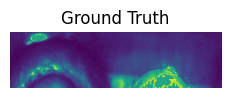

In [52]:
# printing img testset 

inp, re = load(testset_files[1])
ar_inp,_,_ = tf.split(inp, num_or_size_splits=3, axis=-1)

norm_ar = tf_daugman_normalization(ar_inp)

plt.figure(figsize=(6, 6))

display_list = [norm_ar]
title = ['Ground Truth']

for i in range(1):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')

plt.show()

In [53]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    fi_real_image = []
    input_image,_,_ = tf.split(input_image, num_or_size_splits=3, axis=-1)
    real_image,_,_ = tf.split(real_image, num_or_size_splits=3, axis=-1)

    norm_input_image = tf_daugman_normalization(input_image)
    norm_real_image = tf_daugman_normalization(real_image)
    fi_real_image = tf_daugman_feature_extractor(norm_real_image)
    
    return norm_input_image, fi_real_image

In [54]:
if dataset == 'hk_dataset' :
    f = 'test/*.png'

if hk_validation :
    test_dataset = tf.data.Dataset.from_tensor_slices(testset_files)
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(1)
else :
    test_dataset = tf.data.Dataset.list_files(str(PATHLIB_DATASET_PATH / f), shuffle=False)
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(1)

In [55]:
def generator_loss(target, gen_output):
    # PSNR 
    psnr_loss = tf.image.psnr(target, gen_output, max_val=2.0) # images shuld have been normalized in range [-1,1]. Thus, the difference between the min and max should be 2.
    
    # SSIM 
    ssim_loss = tf.image.ssim(target, gen_output, max_val=2.0)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Mean squared error
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output)**2)
    
    return psnr_loss.numpy().item(0), ssim_loss.numpy().item(0), l1_loss.numpy(), l2_loss.numpy()


def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask

def DiceLoss(targets, inputs, smooth=1e-6):

    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice


def IoULoss(targets, inputs, smooth=1e-6):

    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU


def fe_loss(y_true, y_pred) :

    # OHE + flatten representation 

    mask_prediction = create_mask(y_pred)
    mask_prediction = tf.cast(mask_prediction, tf.uint8)

    y_true = K.squeeze(y_true, 3)
    y_true = tf.cast(y_true, "int32")
    y_true_OHE = tf.one_hot(y_true, 4, axis=-1)

    mask_prediction = K.squeeze(mask_prediction, 3)
    mask_prediction = tf.cast(mask_prediction, "int32")
    mask_prediction_OHE = tf.one_hot(mask_prediction, 4, axis=-1)  
    
    y_true = K.cast(y_true_OHE, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    mask_prediction =  K.cast(mask_prediction_OHE, 'float32')
    
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    mask_prediction = K.flatten(mask_prediction)


    #accuracy   -   precision   -   recall   

    accuracy = tf.keras.metrics.Accuracy()
    accuracy.reset_states()

    precision = tf.keras.metrics.Precision()
    precision.reset_states()

    recall = tf.keras.metrics.Recall()
    recall.reset_states()

    accuracy.update_state(y_true, mask_prediction)
    precision.update_state(y_true, mask_prediction)
    recall.update_state(y_true, mask_prediction)

    # f1score

    precision_result = precision.result().numpy()
    recall_result = recall.result().numpy()
    f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result)

    # Log Loss

    categoricalcrossentropy = tf.keras.metrics.CategoricalCrossentropy()
    categoricalcrossentropy.reset_states()
    categoricalcrossentropy.update_state(y_true_OHE, mask_prediction_OHE)

    #dice_loss 

    dice_loss = DiceLoss(y_true, mask_prediction)
    
    #dice_loss 
    
    iou_loss =  IoULoss(y_true, mask_prediction)

    return accuracy.result().numpy(), dice_loss, iou_loss, categoricalcrossentropy.result().numpy(), precision_result, recall_result, f1_score

In [56]:
for model_name in models_list :
    generator = tf.keras.models.load_model(MODELS_PATH + model_name + '.h5', compile=False)
    model_images_path = GENERATED_IMAGES_PATH + model_name
    #mkdir(model_images_path)

    sum_acc = []
    sum_dice_loss = [] 
    sum_iou_loss = [] 
    sum_logloss = []
    sum_precision = []
    sum_recall = []
    sum_f1score = []

    n_image = 0
    for inp, tar in test_dataset :
        gen_output = generator(inp, training=False)

        #print_images(gen_output, inp)

        if dataset == 'hk_dataset' : 
            acc, dice_loss, iou_loss, logloss, precision, recall, f1score = fe_loss(tar, gen_output)

            sum_acc.append(acc)
            sum_dice_loss.append(dice_loss)
            sum_iou_loss.append(iou_loss)
            sum_logloss.append(logloss)
            sum_precision.append(precision)
            sum_recall.append(recall)
            sum_f1score.append(f1score)
  
        #save_image(gen_output, tar, model_images_path, n_image)
        n_image = n_image + 1

    if dataset == 'hk_dataset' : 
        print('\t' + model_name)
        print("\t  acc ")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_acc)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_acc)))
        print("\t  precision")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_precision)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_precision)))
        print("\t  recall")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_recall)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_recall)))
        print("\t  f1 score")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_f1score)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_f1score)))
        print("\t  categoricalcrossentropy")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_logloss)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_logloss)))
        print("\t  dice loss")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_dice_loss)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_dice_loss)))
        print("\t  iou loss")
        print("\t\t  mean  : " +  "{:.2f}".format(np.mean(sum_iou_loss)) +  "\tvar : " +  "{:.2f}".format(np.var(sum_iou_loss)))
        print("\n\n")





	best_pix2pix_bs4_dice_loss_LP_5
	  acc 
		  mean  : 0.68	var : 0.00
	  precision
		  mean  : 0.35	var : 0.01
	  recall
		  mean  : 0.35	var : 0.01
	  f1 score
		  mean  : 0.35	var : 0.01
	  categoricalcrossentropy
		  mean  : 10.43	var : 1.58
	  dice loss
		  mean  : 0.65	var : 0.01
	  iou loss
		  mean  : 0.78	var : 0.00



	best_unet_bs4_dice_loss
	  acc 
		  mean  : 0.68	var : 0.00
	  precision
		  mean  : 0.35	var : 0.01
	  recall
		  mean  : 0.35	var : 0.01
	  f1 score
		  mean  : 0.35	var : 0.01
	  categoricalcrossentropy
		  mean  : 10.42	var : 1.63
	  dice loss
		  mean  : 0.65	var : 0.01
	  iou loss
		  mean  : 0.78	var : 0.01



